## iCLOTS: interactive Cellular Labeled Observation and Tracking Software ##

### v0.1.0 machine learning approach ###

Machine learning analysis of iCLOTS-generated data using k-means clustering, as described in peer-reviewed publication

Clustering is an unsupervised machine learning technique designed to mathematically characterize natural groupings within datasets. You may find this approach useful for tasks such as investigating healthy/clinical dichotomies or single-sample subpopulations within potentially large datasets. 

The iCLOTS development team suggests the following review paper for better understanding of machine learning techniques, including clustering with k-means algorithms:
- [A guide to machine learning for biologists](https://www.nature.com/articles/s41580-021-00407-0) by Greener et al.

Briefly:
- User provides one or more excel files, each representing a single sample and containing single data points (e.g., cells) described using the same features (numerical metrics, e.g. area, circularity, or sDI)
- User selects two or more features to use for clustering analysis
- A scree plot is generated to inform an optimal number of mathematically significant clusters to retain
- All data points are partitioned into clusters that minimize the differences between shared metrics within each group
- All data points are returned with a corresponding cluster lab for further statistical interpretation
- Statistics including silhoutte score are returned to assess relative goodness of clustering

Inputs:
- Number of clusters

Outputs:
- Data points with labels
- Silhoutte score
- Scatter plot overlaid on cluster boundaries
- Mosaic plot of cluster contributions of each label

In [1]:
# Import libraries
#   File management
from tkinter import filedialog  # For selecting files
import os  # For directory management
import glob
import shutil
#   Number, file, and image management
import cv2  # Computer vision/image processing
from scipy.ndimage import label
from scipy import stats
from skimage import measure, util
import seaborn as sns
from sklearn.model_selection import train_test_split  # For machine learning approach
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture # ""
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix  # " "
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score  # " "
import numpy as np  # For array management
import pandas as pd  # For database management
import random
from pandas import Series
#   Plotting results
import matplotlib.pyplot as plt  # For plotting result data
import matplotlib.patches as mpatches  # For keys
from matplotlib import colors
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import datetime
import itertools
from statsmodels.graphics.mosaicplot import mosaic

**Step 1: Select a directory containing one or more excel files, each representing a single sample.** All excel datasets should contain the same metrics for further analysis. Excel datasheets should consist of one sheet only: single data points described by metrics. Name the excel files meaningfully as names will be used as the sample labels.

In [2]:
# Select directory
directory = filedialog.askdirectory()

# Create a list of excel sheets
filelist = glob.glob(directory + "/*.xlsx")

In [3]:
# Create a "results" folder within the original directory to save results to
now = datetime.datetime.now()

# Create timestamped results directory
output_folder = os.path.join(directory, 'Results, ' + now.strftime("%m_%d_%Y, %H_%M_%S"))
os.mkdir(output_folder)
os.chdir(output_folder)

# Print current working directory
# If you run this cell additional times, multiple directories will be created - results will be in most recent
print(os.getcwd())

/Users/meredithfay/Documents/iCLOTS_test_data/Machine_learning_set1/Results, 12_15_2022, 13_23_19


In [4]:
# Combine all excel sheets into one large dataframe based on shared columns
df = pd.DataFrame()  # Initial

for filename in filelist:
    # Read excel
    sheet = pd.read_excel(filename, engine='openpyxl')

    samplename = os.path.basename(filename).split('.')[0]  # Sample name: name of excel sheet (remove .xlsx)
    sheet['Sample'] = samplename  # Add as column
    df = df.append(sheet, ignore_index=True)
    
print(df.head(10))

              Image  Index            x          y  Area (pix)  Area (μm²)  \
0  fib_herm_100ug_1      0    31.661337   9.302326         688   18.958528   
1  fib_herm_100ug_1      1    97.650888   2.668639         169    4.656964   
2  fib_herm_100ug_1      2   211.264706  23.408304        2312   63.709472   
3  fib_herm_100ug_1      3   407.382734  15.648921        1390   38.302840   
4  fib_herm_100ug_1      4   626.005731  16.622493        1396   38.468176   
5  fib_herm_100ug_1      5   877.991416   7.952790         233    6.420548   
6  fib_herm_100ug_1      6  1307.899740  14.850909        1925   53.045300   
7  fib_herm_100ug_1      7  1651.862528   5.594235         451   12.427756   
8  fib_herm_100ug_1      8  1815.158031   8.362694         386   10.636616   
9  fib_herm_100ug_1      9  1860.036576  22.497276        1285   35.409460   

   Circularity (a.u.)  Texture (a.u.)  Signal (binary)  \
0            0.767415        6.861690                0   
1            0.960368    

In [5]:
# Find common columns
# (See test column in example: only one sample has values, other appended sheets show a NaN value)

# Columns without NaN
print(df.columns[~df.isnull().any()])

Index(['Image', 'Index', 'x', 'y', 'Area (pix)', 'Area (μm²)',
       'Circularity (a.u.)', 'Texture (a.u.)', 'Signal (binary)',
       'Fn. stain intensity (a.u.)', 'Sample'],
      dtype='object')


**Step 2: Select two or more features.**

In [6]:
# From the common columns, please input two or more columns of interest as exact strings within a list
# Strings have case-sensitive text surrounded by quotes
# Lists are surrounded by square brackets
# Note that many iCLOTS outputs contain (μm²) as outputs. To include these in strings:
# # replace μ with \u03bc, replace ² with \u00b2

# i.e. input_columns = ['metric 1', 'metric 2']
input_columns = ['Circularity (a.u.)', 'Area (\u03bcm\u00b2)', 'Fn. stain intensity (a.u.)']  # Edit

print(input_columns)  # Useful to check unicode (if any) is correctly formatted

['Circularity (a.u.)', 'Area (μm²)', 'Fn. stain intensity (a.u.)']


In [7]:
# Add sample to list
columns = ['Sample'] + input_columns
df_for_analysis = df[columns]

print(df_for_analysis.head())

           Sample  Circularity (a.u.)  Area (μm²)  Fn. stain intensity (a.u.)
0  HPS_fibrinogen            0.767415   18.958528                           0
1  HPS_fibrinogen            0.960368    4.656964                           0
2  HPS_fibrinogen            0.740301   63.709472                           0
3  HPS_fibrinogen            0.794173   38.302840                           0
4  HPS_fibrinogen            0.714755   38.468176                           0


In [8]:
# Remove any lines with Nan, infinity values
df_for_analysis.replace(np.inf, np.nan, inplace=True)
df_for_analysis.dropna(inplace=True)
print(df_for_analysis.head())

           Sample  Circularity (a.u.)  Area (μm²)  Fn. stain intensity (a.u.)
0  HPS_fibrinogen            0.767415   18.958528                           0
1  HPS_fibrinogen            0.960368    4.656964                           0
2  HPS_fibrinogen            0.740301   63.709472                           0
3  HPS_fibrinogen            0.794173   38.302840                           0
4  HPS_fibrinogen            0.714755   38.468176                           0


/Users/meredithfay/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/Users/meredithfay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


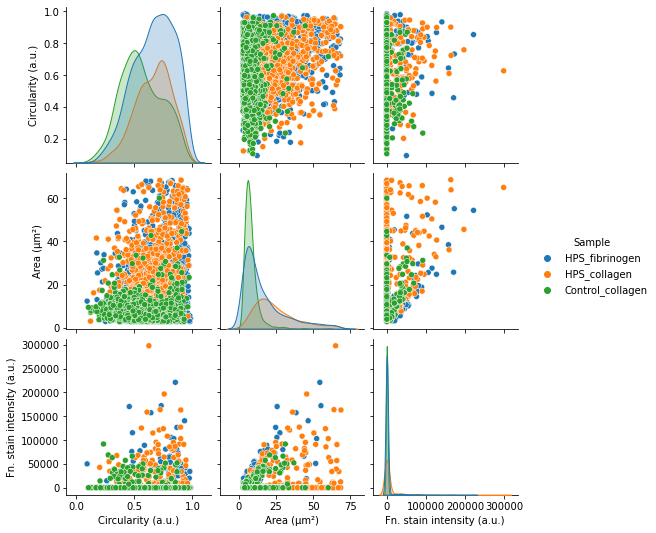

In [9]:
# Display and save a pairplot showing relationships between features
sns.pairplot(df_for_analysis, hue="Sample")
plt.savefig('Selected_features_pairplot.png', dpi=300)  # Save in results folder
plt.show()

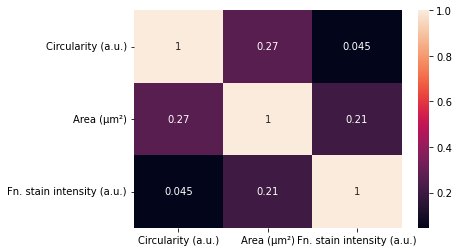

In [10]:
# Create correlation matrix
# May want to remove highly correlated values (approaching -1 or 1)
# Remember that all values on leading diagonal (comparing metric to itself) will always be 1

df_X = df_for_analysis[input_columns]  # Numerical data only, will also be used for clustering
corrMatrix = df_X.corr()
sns.heatmap(corrMatrix, annot=True)
plt.savefig('Selected_features_correlation-matrix.png', dpi=300)  # Save in results folder
plt.show()

**Step 3: A scree plot informs optimal number of mathematically significant clusters to retain.** The "elbow point" of a scree plot line is considered optimal.

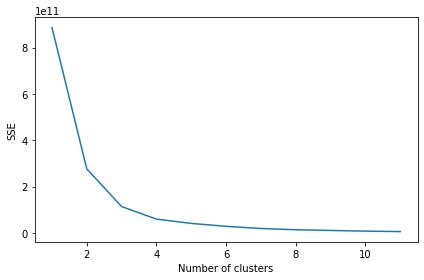

In [11]:
# Create scree plot
sse = {}
df_scree = df_X.copy()  # Leave original X set unchanged
for k in range(1, 12):  # Range of 1 to 12 clusters, could easily edit
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_scree)
    df_scree["Clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.tight_layout()
plt.savefig('Selected_features_scree.png', dpi=300)

# In provided example, see elbow point at k=2 clusters

In [12]:
# After consulting the scree plot, please input a number of clusters (k) to parition all data points into
# i.e. k = 2
k = 3 # Edit

**Step 4: All data points are partioned into clusters.**

See [scikit-learn docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for additional information, including hyper-parameter settings you may wish to adjust.

In [13]:
# Partition clusters
kmeans = KMeans(n_clusters=k, random_state=100)
kmeans_labels = kmeans.fit_predict(df_X)  # Note each label will be an integer, starting at 0 (0, 1, 2.. etc.)

In [14]:
# Create new dataframe that includes sample name, all feature metric values, and labels
df_with_labels = df_for_analysis.copy()
df_with_labels['Label'] = kmeans_labels
print(df_with_labels.head())

           Sample  Circularity (a.u.)  Area (μm²)  Fn. stain intensity (a.u.)  \
0  HPS_fibrinogen            0.767415   18.958528                           0   
1  HPS_fibrinogen            0.960368    4.656964                           0   
2  HPS_fibrinogen            0.740301   63.709472                           0   
3  HPS_fibrinogen            0.794173   38.302840                           0   
4  HPS_fibrinogen            0.714755   38.468176                           0   

   Label  
0      0  
1      0  
2      0  
3      0  
4      0  


In [15]:
# Create excel writer
writer = pd.ExcelWriter('Clustering_analysis.xlsx', engine='openpyxl')  # To write excel sheets

# Sheet 1: save sample/label dataframe
df_with_labels.to_excel(writer, sheet_name='Data with labels', index=False)

In [16]:
# Create a 2D scatter plot of labels from all combinations of two features
graph_count = 1  # For saving figures

for pair in itertools.combinations(input_columns, 2):
    sns.scatterplot(data=df_with_labels, x=pair[0], y=pair[1], hue='Sample', style='Label')  # Color: sample, shape: label
    plt.xlabel(pair[0])
    plt.ylabel(pair[1])
    plt.tight_layout()
    plt.savefig('Paired_features_' + str(graph_count) + '.png', dpi=300)
    plt.close()
    graph_count +=1 # Some feature column names may contain unicode characters unsuitable for file names
    
# Users will need to sort through graphs to find interesting combinations

In [17]:
# If you are using only two features to describe data points, you may find the following code useful
# Plots each sample as scatterpoints over a mesh background describing sample boundaries
# Not necessarily debugged

# # Step size of the mesh. Decrease to increase the quality of the VQ.
# h = 10     # point in the mesh [x_min, x_max]x[y_min, y_max].

# # Set min/max values.
# x_min, x_max = X_2.iloc[:, 0].min() - 1, X_2.iloc[:, 0].max() + 1
# y_min, y_max = 0, X_2.iloc[:, 1].max() + 1

# # Create mesh grid
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# # Obtain labels for each point in mesh. Use last trained model.
# # Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])


# # Put the result into a color plot
# Z = Z.reshape(xx.shape)

# plt.imshow(Z, interpolation='nearest',
#        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#        cmap=colors.ListedColormap(['#ddadfd', '#fff7b1']),  # Purple and yellow, could edit
#        aspect='auto', origin='lower')


# # Replace 'metric 1' and 'metric 2' with actual dataframe column names
# plt.scatter(df_with_labels['metric 1'], df_with_labels['metric 2'], c=df_with_labels['Sample'])

# # Set graph limits
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(()) # Remove ticks
# plt.yticks(())
# plt.xlabel('metric 1')  # Axis labels, replace string with actual metric names
# plt.ylabel('metric 2')
# plt.tight_layout()

# plt.savefig('Labels_and_boundaries.png', dpi=300)
# plt.show()
# plt.close()

**Step 5: Additional numerical outputs.**

In [18]:
# Silhouette score to assess goodness of clustering
# -1 indicates poor clustering, 1 indicates perfect clustering
silhouette_coefficient = metrics.silhouette_score(df_X, kmeans_labels)
print("Silhouette coefficient: " + str(silhouette_coefficient))

dict_sc = {'Silhouette coefficient': silhouette_coefficient}  # Dict
dict_df = pd.DataFrame(dict_sc, index=[0])  # Dataframe
dict_df.to_excel(writer, sheet_name='Sil. coeff.', index=False)

Silhouette coefficient: 0.9599309509249038


In [19]:
# Metrics suited for Chi-square analysis 
# Number of cells in each labeled group
count_series = df_with_labels.groupby(['Sample', 'Label']).size()
count_series_df = count_series.to_frame(name = 'size').reset_index()
count_series_df.to_excel(writer, sheet_name='Sample, label counts', index=False)

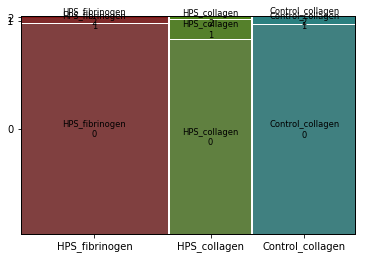

In [20]:
# Mosaic plot describing number of events from each sample within each cluster
# It's not trivial to label each element of the plot with a count
# # See https://medium.com/analytics-vidhya/hello-everyone-4f9400e008dc for an example of a labelizer lambda function
mosaic(df_with_labels, ['Sample', 'Label'])
plt.savefig('Mosaic_plot.png', dpi=300)
plt.show()

In [21]:
# Save and close writer to export results excel
writer.save()
writer.close()

**Comments, questions, or concerns?** Check out [iCLOTS.org](www.iclots.org) and contact us using the form on the website or by [emailing](mailto:lamlabcomputational@gmail.com). We welcome all feedback. Thanks for being an iCLOTS user!